In [1]:
import os, sys
currentdir = os.getcwd()
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, currentdir) 
sys.path.insert(0, parentdir) 

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

import numpy as np
import scipy
from scipy.integrate import odeint, DOP853, solve_ivp
from scipy.stats import special_ortho_group
from scipy.linalg import qr
from itertools import chain, combinations, permutations

import seaborn as sns

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def relu_step_input(x, W, b, W_ih, I):
    res = np.array(np.dot(W,x) + b + np.dot(W_ih, I))
    res[res < 0] = 0
    return res

def find_analytic_fixed_points(W_hh, b, W_ih, I, tol=10**-4):
    """
    Takes as argument all the parameters of the recurrent part of the model (W_hh, b) with a possible input I that connects into the RNN throught the weight matrix W_ih
    """
    fixed_point_list = []
    stabilist = []
    unstabledimensions = []
    Nrec = W_hh.shape[0]
    
    subsets = powerset(range(Nrec))
    for support in subsets:

        if support == ():
            continue
        r = np.array(support)
        
        #invert equation
        fixed_point = np.zeros(Nrec)
        fpnt_nonzero = -np.dot(np.linalg.inv(W_hh[r[:,None], r]-np.eye(len(support))), b[r] + np.dot(W_ih[r,:], I))
        fixed_point[r] = fpnt_nonzero
        
        #check whether it is a fixed point: zero derivative
        # if fnpt_i > 0 for all i=1, ..., Nrec
        if np.all(fixed_point >= 0) and np.all(np.abs(fixed_point-relu_step_input(fixed_point, W_hh, b, W_ih, I))<tol):
            fixed_point_list.append(fixed_point)
        
            #check stability
            eigenvalues = np.linalg.eigvals(W_hh[r[:,None], r]-np.eye(len(support)))
            if np.any(eigenvalues>0.):
                # print("Unstable")
                stabilist.append(0)
            else:
                # print("Stable")
                stabilist.append(1)
            unstabledimensions.append(np.where(np.real(eigenvalues)>0)[0].shape[0])
    return fixed_point_list, stabilist, unstabledimensions

sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 1})
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

def ReLU(x):
    return np.where(x<0,0,x)

def sigmoid(x):
    return 1/(1+np.exp(-x))

def linear_ode(t,x,W,b,tau=1):
    return (np.dot(W,x)+b)/tau

def relu_ode(t,x,W,b):
    return ReLU(np.dot(W,x)+b) - x 

def sigmoid_ode(t,x,W,b):
    return sigmoid(np.dot(W,x)+b) 

def tanh_ode(t,x,W,b,tau):
    return (-x + np.dot(W,np.tanh(x))+b)/tau

def relu_adj_ode(t,x,W,tau,x_solved):
    return np.dot(-(-np.eye(W.shape[0]) + np.multiply(W, np.where(np.dot(W,x_solved(t))+b>0,1,0))).T/tau, x)

def tanh_adj_ode(t,x,W,tau,x_solved):
    return np.dot(-(-np.eye(W.shape[0]) + np.multiply(W,1/np.cosh(x_solved(t))**2)).T/tau, x)

def stab_mat_ode(t,Y,W,tau,x_solved,N):
    J = tanh_jacobian(t,W,tau,x_solved).flatten()

    return np.dot(J,Y)

def linear_jacobian(t,W,b,tau,x_solved):
    #b is unused, but there for consistency with relu jac
    return W/tau


def tanh_jacobian(t,W,b,tau,x_solved):
    #b is unused, but there for consistency with relu jac
    return (-np.eye(W.shape[0]) + np.multiply(W,1/np.cosh(x_solved(t))**2))/tau


def relu_jacobian(t,W,b,tau,x_solved):
    return (-np.eye(W.shape[0]) + np.multiply(W, np.where(np.dot(W,x_solved(t))+b>0,1,0)))/tau


def calculate_lyapunov_spectrum(act_fun,W,b,tau,x_solved,t,delta_t,N,from_t_step=0):
    Q_n = np.eye(N)
    lyap_spec = np.zeros(N)
    lyaps = []
    N_t = t.shape[0]
    for n in range(from_t_step,N_t):
        t_n = t[n]
        M_n = np.eye(N) + act_fun(t_n,W,b,tau,x_solved)*delta_t
        Q_n, R_n = np.linalg.qr(np.dot(M_n, Q_n))
        lyap_spec += np.log(np.abs(np.diag(R_n)))/(N_t*delta_t)
        lyaps.append(lyap_spec)
    return lyap_spec, lyaps


In [2]:
np.random.seed(10)

### One fixed point

In [24]:
np.random.seed(10)
N_1 = 6
# b = np.random.normal(0,.5,N_1)
# A = -.5*np.eye(N_1)
# A += np.random.normal(0,.1,(N_1,N_1))

In [25]:
# np.savetxt("A_1.csv", A, delimiter=",")
# np.savetxt("b_1.csv", b, delimiter=",")

A = np.loadtxt("A_1.csv", delimiter=",")
b = np.loadtxt("b_1.csv", delimiter=",")

fixed_point_1 = -np.dot(np.linalg.inv(A), b)
fixed_point_1

array([ 0.54413868,  0.43525095, -0.73316566, -1.3268147 ,  1.95530336,
       -0.83472816])

In [26]:
t0, t1 = 0, 20
t = np.linspace(t0,t1,101)
delta_t = (t1-t0)/t.shape[0]
y0 = np.random.normal(0,1,N_1).squeeze()

In [37]:
np.random.seed(10)
N_sols = 50
sols_1 = np.zeros((N_sols,N_1,t.shape[0]))
sols_adjoint_1 = np.zeros((N_sols,N_1,t.shape[0]))

for i in range(N_sols):
    y0 = np.random.normal(.5,1,(N_1))
    sol = solve_ivp(linear_ode, t_span=[t0, t1], t_eval=t, y0=y0, args=([A,b]), dense_output=True)
    sols_1[i,...] = sol.sol(t)
    y0 = np.random.normal(.5,1,(N_1))
    sol_adjoint_1 = solve_ivp(linear_ode, t_span=[t1, t0], t_eval=t[::-1], y0=y0, args=([-A.T,0]), dense_output=True).sol(t)
    sols_adjoint_1[i,...] = sol_adjoint_1
eigenvalues, _ = np.linalg.eig(A)

Q_old = np.eye(N_1)
lyap_spec_1 = np.zeros(N_1)
lyaps = []
tau=1
for n in range(t.shape[0]):
    t_n = t[n]
    M_n = np.eye(N_1) + relu_jacobian(t_n,A,b,tau,sol.sol)*delta_t
    Q_n, R_n = np.linalg.qr(np.dot(M_n, Q_old))
    Q_old = Q_n
    lyap_spec_1 += np.log(np.abs(np.diag(R_n)))/(t.shape[0]*delta_t)
    lyaps.append(lyap_spec_1)

sol_1 = sol.sol(t)
x_solved = sol.sol
lyap_spec_1, lyaps = calculate_lyapunov_spectrum(linear_jacobian,A,b,tau,x_solved,t,delta_t,N_1)


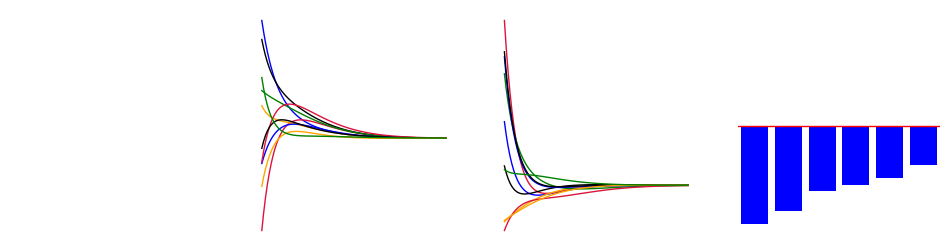

In [38]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3), sharex=False, sharey=False)
axs = axs.reshape((1,-1))
[axi.set_axis_off() for axi in axs.ravel()];
[axi.set_prop_cycle(color=['b', 'crimson', 'k', 'orange', 'g']) for axi in axs.ravel()];

for i in range(10):
    axs[0,1].plot(sols_1[i,0,:].T)
    axs[0,2].plot(sols_adjoint_1[i,0,::-1].T)
axs[0,3].bar(range(N_1), sorted(lyap_spec_1))
axs[0,3].plot((-N_1,2*N_1), (0,0), 'r')
axs[0,3].set(xlim=(-.5,N_1-0.5),ylim=(-1,1));
axs[0,3].set_yticks([0],[0])
# axs[0,0].yaxis.tick_right()

### Two fixed points

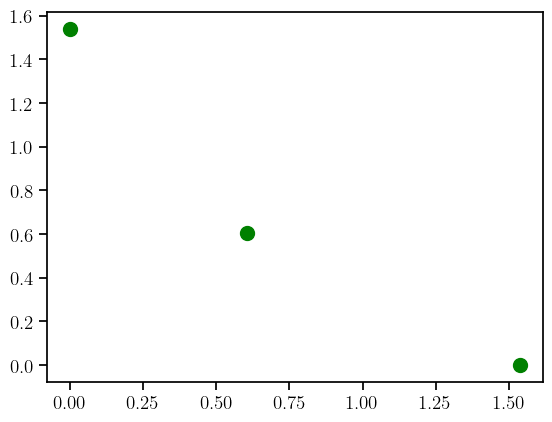

In [8]:
W = np.array([[0.5,-1,0],[-1,0.3,0],[0,0,-4]])
W = np.array([[.35,-1,0,0,0,0],[-1,.35,0,0,0,0],[0,0,-.01,0,0,0],[0,0,0,-.02,0,0],[0,0,0,0,-.03,0],[0,0,0,0,.0,-0.01]])

b = np.array([1,1,1])
b = np.array([1,1,1,1,1,1])

fixed_point_list, stabilist, unstabledimensions = find_analytic_fixed_points(W, b, W_ih=np.zeros((N_1,N_1)), I=[0,0,0,0,0,0], tol=10**-4)

for fxdpnt in fixed_point_list:
    plt.plot(fxdpnt[0], fxdpnt[1], 'o', color='green', markersize=10)

In [9]:
def fp2_ode(t,x,W,b):
    return [x[0]-x[1], -x[0]-x[1], x[2]]

# from analysis_functions import find_analytic_fixed_points
# find_analytic_fixed_points(W, b, 0*W, [0,0,0], tol=10**-4)

In [10]:
np.random.seed(10)

y0 = np.array([0.1,.2,.3,0.2,0.1,0.1])

sol = solve_ivp(relu_ode, t_span=[t0, t1], t_eval=t, y0=y0, args=([W,b]), dense_output=True)

sol_adjoint_2 = solve_ivp(relu_ode, t_span=[t1, t0], t_eval=t[::-1], y0=sol.sol(t)[:,-1], args=([-W.T,0]), dense_output=True).sol(t)

J = 1/np.cosh(W)
eigenvalues, _ = np.linalg.eig(W)

# lyap_spec_2 = nolds.lyap_e(sol.sol(t)[1,:], emb_dim=N_1,  matrix_dim=N_1)

Q_old = np.eye(N_1)
lyap_spec_2 = np.zeros(N_1)
for n in range(t.shape[0]):
    t_n = t[n]
    M_n = np.eye(N_1) + relu_jacobian(t_n,W,b,tau,sol.sol)*delta_t
    Q_n, R_n = np.linalg.qr(np.dot(M_n, Q_old))
    Q_old = Q_n
    lyap_spec_2 += np.log(np.abs(np.diag(R_n)))/(t.shape[0]*delta_t)

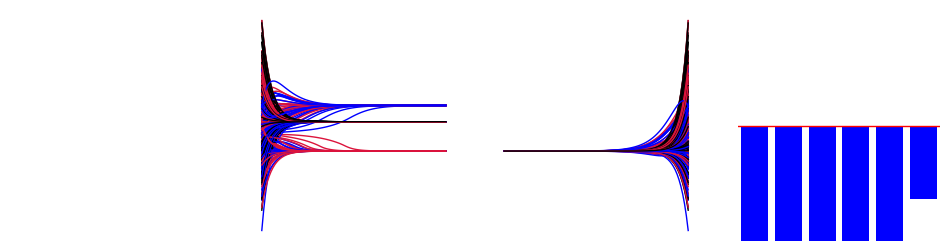

In [11]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3), sharex=False, sharey=False)
axs = axs.reshape((1,-1))
[axi.set_axis_off() for axi in axs.ravel()];
[axi.set_prop_cycle(color=['b', 'crimson', 'k']) for axi in axs.ravel()];

sols_2 = np.zeros((N_sols,N_1,t.shape[0]))
sols_adjoint_2 = np.zeros((N_sols,N_1,t.shape[0]))
for i in range(N_sols):
    y0 = np.array([.5,.5,2,0.3,2,0])+np.random.normal(0,1,(N_1))
    sol = solve_ivp(relu_ode, t_span=[t0, t1], t_eval=t, y0=y0, args=([W,b]), dense_output=True)
    x_solved = sol.sol
    eigenvalues, _ = np.linalg.eig(W)
    axs[0,1].plot(sol.sol(t)[:,:].T)
    sols_2[i,...] = sol.sol(t)
    # sol_adjoint_2 = solve_ivp(relu_ode, t_span=[t1, t0], t_eval=t[::-1], y0=y0, args=([-W.T,0]), dense_output=True).sol(t)
    sol_adjoint_2 = solve_ivp(relu_adj_ode, t_span=[t1, t0], t_eval=t[::-1], y0=y0, args=([W,tau,x_solved]), dense_output=True).sol(t)

    sols_adjoint_2[i,...] = sol_adjoint_2
    axs[0,2].plot(sol_adjoint_2[:,:].T)

lyap_spec_2, lyaps = calculate_lyapunov_spectrum(relu_jacobian,W,b,tau,x_solved,t,delta_t,N_1)

axs[0,3].bar(range(N_1), sorted(lyap_spec_2))
axs[0,3].plot((-N_1,2*N_1), (0,0), 'r')
axs[0,3].set(xlim=(-.5,N_1-0.5),ylim=(-1,1));

### Line attractor

In [12]:
W = np.array([[0.,-1,0],[-1,0.,0],[0,0,-2]])
b = np.array([1,1,1])

W = np.array([[0.,-1,0,0,0,0],[-1,0.,0,0,0,0],[0,0,-2,0,0,0],[0,0,0,-2,0,0],[0,0,0,0,-2,0],[0,0,0,0,0,-2]])
b = np.array([1,1,1,1,1,1])

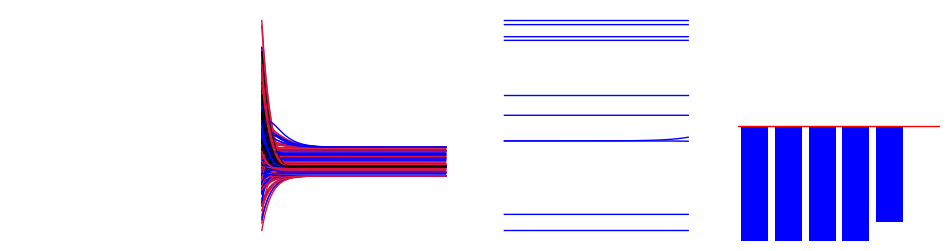

In [13]:
np.random.seed(10)
fig, axs = plt.subplots(1, 4, figsize=(12, 3), sharex=False, sharey=False)
axs = axs.reshape((1,-1))
[axi.set_axis_off() for axi in axs.ravel()];
[axi.set_prop_cycle(color=['b', 'crimson', 'k']) for axi in axs.ravel()];

sols_line = np.zeros((N_sols,N_1,t.shape[0]))
sols_adjoint_line = np.zeros((N_sols,N_1,t.shape[0]))

for i in range(N_sols):
    y0 = np.array([.5,.5,2,2,3,2])+np.random.normal(0,1,(N_1))
    sol = solve_ivp(relu_ode, t_span=[t0, t1], t_eval=t, y0=y0, args=([W,b]), dense_output=True)
    eigenvalues, _ = np.linalg.eig(W)
    x_solved = sol.sol
    axs[0,1].plot(sol.sol(t)[:,:].T)
    x_solved = sol.sol
    sols_line[i,...] = sol.sol(t)
    # sol_adjoint_line = solve_ivp(relu_ode, t_span=[t1, t0], t_eval=t[::-1], y0=y0, args=([-W.T,0]), dense_output=True).sol(t)
    # y0 = np.ones(N_1)
    sol_adjoint_line = solve_ivp(relu_adj_ode, t_span=[t1, t0], t_eval=t[::-1], y0=y0, args=([W,tau,x_solved]), dense_output=True).sol(t)

    sols_adjoint_line[i,...] = sol_adjoint_line

tau = 1
lyap_spec_line, lyaps = calculate_lyapunov_spectrum(relu_jacobian,W,b,tau,x_solved,t,delta_t,N_1)

for i in range(10):
        axs[0,2].plot(sols_adjoint_line[i,0,20:70], 'b')
axs[0,3].bar(range(N_1), sorted(lyap_spec_line))
axs[0,3].plot((-N_1,2*N_1), (0,0), 'r')
axs[0,3].set(xlim=(-.5,N_1-0.5),ylim=(-3,3));

### Chaos

In [14]:
W = np.loadtxt("W_200_chaos.csv", delimiter=",")
N_chaos = 100
g = 1.8
tau = 10/1000.
# mask = np.where(np.random.random((N_chaos,N_chaos))>0.9,1,0)
# W = np.dot(np.random.normal(0,g/np.sqrt(N_chaos),(N_chaos,N_chaos)), mask)
# eigenvalues, _ = np.linalg.eig(W-np.eye(N_chaos))
b = np.ones(N_chaos)*0

In [15]:
np.random.seed(10)
t_shift = 200
t0, t1 = 0, 20
t_chaos = np.linspace(t0,t1,5000)
delta_t = (t1-t0)/t_chaos.shape[0]
y0_0 = np.random.normal(0,2,N_chaos).squeeze()

N_sols = 10
sols_chaos = np.zeros((N_sols,N_chaos,t_chaos.shape[0]))
sols_adjoint_chaos = np.zeros((N_sols,N_chaos,t_chaos.shape[0]))
for i in range(N_sols):
    y0 = y0_0 + np.random.normal(0,1e-4,N_chaos).squeeze()
    sol = solve_ivp(tanh_ode, t_span=[t0, t1], t_eval=t_chaos, y0=y0, args=([W,b,tau]), dense_output=True)
    x_solved = sol.sol
    sols_chaos[i,...] = sol.sol(t_chaos)
    y0_adj = np.random.normal(0,1e-4,N_chaos).squeeze()
    sol_adjoint_chaos = solve_ivp(tanh_adj_ode, t_span=[t1, t0], t_eval=t_chaos[::-1], y0=y0_adj, args=([W,tau,x_solved]), dense_output=True).sol(t_chaos)
    sols_adjoint_chaos[i,...] = sol_adjoint_chaos

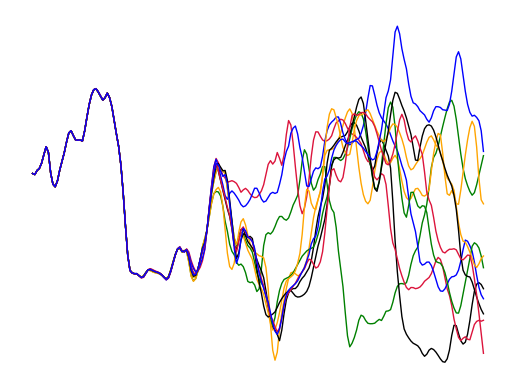

In [16]:
fig, ax = plt.subplots(1, 1)
ax.set_axis_off()
ax.set_prop_cycle(color=['b', 'crimson', 'k', 'orange', 'g'])

for i in range(N_sols):
    ax.plot(t_chaos[:t_shift],sols_chaos[i,0,:t_shift].T,zorder=-i)

plt.savefig("chaos_trials.pdf")

In [17]:
y0_adj = np.random.normal(0,1,N_chaos).squeeze()
sol_chaos = sol.sol(t_chaos)
lyap_spec_chaos, lyaps = calculate_lyapunov_spectrum(tanh_jacobian,W,0,tau,x_solved,t_chaos,delta_t,N_chaos,from_t_step=1000)
sorted(lyap_spec_chaos)[-10:]

[-32.518713857968784,
 -27.96767039743429,
 -21.497860638079555,
 -15.497916805573558,
 -7.946427401031307,
 -0.39712914108581016,
 4.932152416362451,
 12.431701314594386,
 18.53828791967397,
 24.50887495121315]

Text(0.5, 0, 'Spectrum')

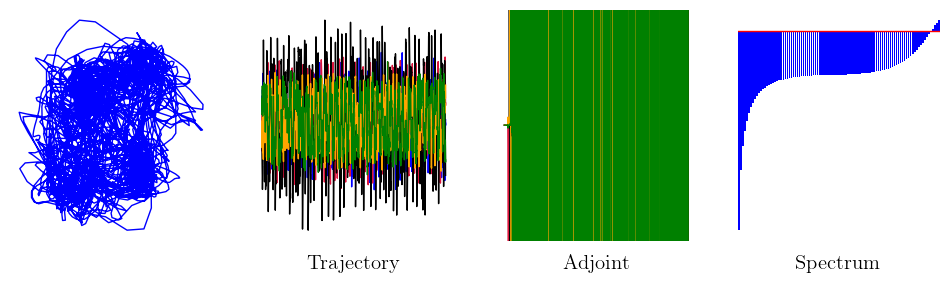

In [18]:
fig, axs = plt.subplots(1, 4, figsize=(12,3))
axs = axs.reshape((1,-1))
[axi.set_xticklabels([]) for axi in axs.ravel()];
[axi.set_yticklabels([]) for axi in axs.ravel()];
[axi.set_xticks([]) for axi in axs.ravel()];
[axi.set_yticks([]) for axi in axs.ravel()];
[axi.spines['top'].set_visible(False) for axi in axs.ravel()];
[axi.spines['left'].set_visible(False) for axi in axs.ravel()];
[axi.spines['right'].set_visible(False) for axi in axs.ravel()];
[axi.spines['bottom'].set_visible(False) for axi in axs.ravel()];

[axi.set_prop_cycle(color=['b', 'crimson', 'k', 'orange', 'g']) for axi in axs.ravel()];

axs[0,0].plot(sol_chaos[0,:], sol_chaos[4,:])
axs[0,1].plot(sol_chaos[:5,:].T)
axs[0,2].plot(sol_adjoint_chaos[:5,::-1].T)
axs[0,2].set(ylim=(-15,15));
axs[0,3].bar(range(N_chaos), sorted(lyap_spec_chaos))
axs[0,3].plot((-N_chaos,2*N_chaos), (0,0), 'r')
axs[0,3].set(xlim=(-.5,N_chaos-0.5));

axs[0,0].set_xlabel("")
axs[0,1].set_xlabel("Trajectory")
axs[0,2].set_xlabel("Adjoint")
axs[0,3].set_xlabel("Spectrum")

### Limit cycle

In [19]:
N_lim = 20
g = 1.8
tau = 10/1000.
mask = np.where(np.random.random((N_lim,N_lim))>0.9,1,0)
W_lim = np.dot(np.random.normal(0,g/np.sqrt(N_lim),(N_lim,N_lim)), mask)
eigenvalues, _ = np.linalg.eig(W_lim-np.eye(N_lim))
b = np.zeros(N_lim)

# np.savetxt("W_200_lim.csv", W_lim, delimiter=",")
W_lim = np.loadtxt("W_200_lim.csv", delimiter=",")

In [20]:
np.random.seed(10)
t0, t1 = 0, 20
t_lim = np.linspace(t0,t1,10000)
delta_t = (t1-t0)/t_lim.shape[0]
y0 = np.random.normal(0,1,N_lim).squeeze()
sol = solve_ivp(tanh_ode, t_span=[t0, t1], t_eval=t_lim, y0=y0, args=([W_lim,b,tau]), dense_output=True)
sol_lim = sol.sol(t_lim)
x_solved = sol.sol
sol_adjoint_lim = solve_ivp(tanh_adj_ode, t_span=[t1, t0], t_eval=t_lim[::-1], y0=y0, args=([W_lim,tau,x_solved]), dense_output=True).sol(t_lim)
t_shift = 200

N_sols = 10
sols_lim = np.zeros((N_sols,N_lim,t_lim.shape[0]))
sols_adjoint_lim = np.zeros((N_sols,N_lim,t_lim.shape[0]))
for i in range(N_sols):
    y0 = np.random.normal(0,1,N_lim).squeeze()
    sol = solve_ivp(tanh_ode, t_span=[t0, t1], t_eval=t_lim, y0=y0, args=([W_lim,b,tau]), dense_output=True)
    x_solved = sol.sol
    sols_lim[i,...] = sol.sol(t_lim)
    y0_adj = np.random.normal(0,1,N_lim).squeeze()
    sol_adjoint_lim = solve_ivp(tanh_adj_ode, t_span=[t1, t0], t_eval=t_lim[::-1], y0=y0_adj, args=([W_lim,tau,x_solved]), dense_output=True).sol(t_lim)
    sols_adjoint_lim[i,...] = sol_adjoint_lim

In [21]:
lyap_spec_lim, lyaps = calculate_lyapunov_spectrum(tanh_jacobian,W_lim,0,tau,x_solved,t_lim,delta_t,N_lim,from_t_step=9000)
lyap_spec_lim

array([  0.10635234,  -5.39051538,  -6.7875886 , -10.58473083,
        -9.14854537,  -9.3142926 ,  -9.45750596,  -9.65800484,
       -10.79522723, -11.19088119, -11.08896657, -11.39231596,
       -11.30425242, -12.0449059 , -12.26481447, -14.8570387 ,
       -14.89099793, -20.49288431, -20.75500896, -30.72624607])

Text(0.5, 0, 'Spectrum')

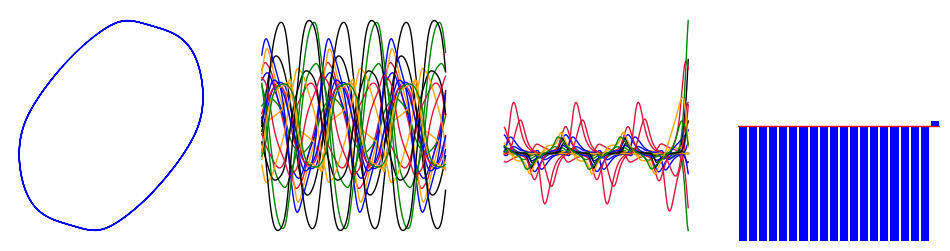

In [22]:
fig, axs = plt.subplots(1, 4, figsize=(12,3))
axs = axs.reshape((1,-1))
[axi.set_axis_off() for axi in axs.ravel()];
[axi.set_prop_cycle(color=['b', 'crimson', 'k', 'orange', 'g']) for axi in axs.ravel()];

t_shift = 200
axs[0,0].plot(sol_lim[0,-t_shift:], sol_lim[1,-t_shift:])
axs[0,1].plot(sol_lim[:,-t_shift:].T)
axs[0,2].plot(sol_adjoint_lim[:,t_shift::-1].T)
axs[0,3].bar(range(N_lim), sorted(lyap_spec_lim))
axs[0,3].plot((-N_lim,2*N_lim), (0,0), 'r')
axs[0,3].set(xlim=(-.5,N_lim-0.5),ylim=(-3,3));

axs[0,0].set_xlabel("")
axs[0,1].set_xlabel("Trajectory")
axs[0,2].set_xlabel("Adjoint")
axs[0,3].set_xlabel("Spectrum")

### Together

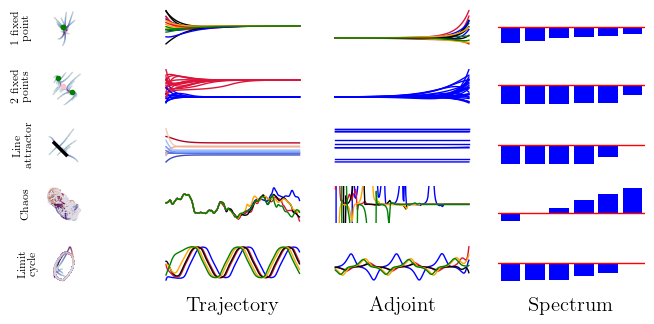

In [23]:
fig, axs = plt.subplots(5, 4, figsize=(7,3.5))
[axi.set_xticklabels([]) for axi in axs.ravel()];
[axi.set_yticklabels([]) for axi in axs.ravel()];
[axi.set_xticks([]) for axi in axs.ravel()];
[axi.set_yticks([]) for axi in axs.ravel()];
[axi.spines['top'].set_visible(False) for axi in axs.ravel()];
[axi.spines['left'].set_visible(False) for axi in axs.ravel()];
[axi.spines['right'].set_visible(False) for axi in axs.ravel()];
[axi.spines['bottom'].set_visible(False) for axi in axs.ravel()];
[axi.set_prop_cycle(color=['b', 'crimson', 'k', 'orange', 'g']) for axi in axs.ravel()];

norm = plt.Normalize(-.5, np.exp(2))
cmap = 'twilight'
fxd_colors = ['pink', 'green']
fxd_markersize = 3
# t_until
N_show = 6

for j in range(5):
    axs[j,0].set(aspect=1)

axs[0,0].set_ylabel("1 fixed \n point", fontsize=8)
axs[0,0].set_aspect(1)
axs[0,0].plot(fixed_point_1[0], fixed_point_1[1], 'o', color='g', markersize=fxd_markersize, zorder=10)
# axs[0,0].plot(sols_1[0,0,-1], sols_1[i,1,-1], 'o', color='g', markersize=fxd_markersize, zorder=10)

axs[0,0].set(xlim=(fixed_point_1[0]-2,fixed_point_1[0]+2),ylim=(fixed_point_1[1]-2,fixed_point_1[1]+2));
axs[0,0].set_aspect(1)
for i in range(15):
    axs[0,0].plot(sols_1[i,0,:], sols_1[i,1,:], 'w', zorder=-10)
    axs[0,1].plot(sols_1[i,1,:].T)
    axs[0,2].plot(sols_adjoint_1[i,0,:].T)

    points = np.array([sols_1[i,0,:], sols_1[i,1,:]]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(t)
    lc.set_linewidth(1)
    line = axs[0,0].add_collection(lc)
axs[0,0].plot(sol_1[0,-1], sol_1[1,-1], 'o', color='g', markersize=fxd_markersize, zorder=10)

axs[0,3].bar(range(N_1), sorted(lyap_spec_1))
axs[0,3].plot((-N_1,2*N_1), (0,0), 'r')
axs[0,3].set(xlim=(-.5,N_1-0.5),ylim=(-1,1));
axs[0,3].set_yticks([0],[0])
# axs[0,3].yaxis.tick_right()



axs[1,0].set_ylabel("2 fixed \n points", fontsize=8)
# axs[1,1].set_prop_cycle(color=['b', 'crimson'])
axs[1,0].set(xlim=(fixed_point_list[-1][0]-2,fixed_point_list[-1][0]+2),ylim=(fixed_point_list[-1][1]-2,fixed_point_list[-1][1]+2));
for i, fxdpnt in enumerate(fixed_point_list):
    axs[1,0].plot(fxdpnt[0], fxdpnt[1], 'o', color=fxd_colors[stabilist[i]], markersize=fxd_markersize, zorder=10)
for i in range(25):
    axs[1,0].plot(sols_2[i,0,:], sols_2[i,1,:], 'w')
    axs[1,1].plot(sols_2[i,0,:].T, color=['b', 'crimson'][int(sols_2[i,0,-1])])
    axs[1,2].plot(sols_adjoint_2[i,0,50:].T, 'b')
    points = np.array([sols_2[i,0,:], sols_2[i,1,:]]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(t)
    lc.set_linewidth(1)
    line = axs[1,0].add_collection(lc)
# axs[1,2].plot(sol_adjoint_2[:,:].T)
axs[1,3].bar(range(N_1), sorted(lyap_spec_2))
axs[1,3].plot((-N_1,2*N_1), (0,0), 'r')
axs[1,3].set(xlim=(-.5,N_1-0.5),ylim=(-1.2,1.));
axs[1,0].set_aspect(1)


axs[2,0].set_ylabel("Line \n attractor", fontsize=8)
axs[2,0].plot((1,0),(0,1), 'k', zorder=10, linewidth=2.5)
for i in range(10):
    axs[2,0].plot(sols_line[i,0,:], sols_line[i,1,:], 'w')
    # axs[2,1].plot(sols_line[i,1,:].T)
    axs[2,2].plot(sols_adjoint_line[i,0,20:70].T, 'b')
    points = np.array([sols_line[i,0,:], sols_line[i,1,:]]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(t)
    lc.set_linewidth(1)
    line = axs[2,0].add_collection(lc)
# axs[2,2].plot(sol_adjoint_line[:,:].T)
axs[2,3].bar(range(N_1), sorted(lyap_spec_line))
axs[2,3].plot((-N_1,2*N_1), (0,0), 'r')
axs[2,3].set(xlim=(-.5,N_1-0.5),ylim=(-4,4));

color = plt.cm.coolwarm(np.linspace(-0.01,1.01,11)) # This returns RGBA; convert:

for i in range(10):
    axs[2,1].plot(sols_line[i,1,:].T, color=color[int(sols_line[i,1,-1]*10)])

axs[3,0].set_ylabel("Chaos", fontsize=8)
axs[3,0].plot(sol_chaos[0,:], sol_chaos[1,:], 'w')
for i in range(5):
    axs[3,0].plot(sols_chaos[i,0,:], sols_chaos[i,1,:], 'w')
    axs[3,1].plot(sols_chaos[i,0,:t_shift].T)
    axs[3,2].plot(sols_adjoint_chaos[i,0,-t_shift:].T)
points = np.array([sols_chaos[0,0,:], sols_chaos[0,1,:]]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(t)
lc.set_linewidth(1)
line = axs[3,0].add_collection(lc)
axs[3,2].set(ylim=(-5,5));
axs[3,3].bar(range(N_show), np.sort(lyap_spec_chaos)[-N_show:])
axs[3,3].plot((-N_show,2*N_show), (0,0), 'r')
# axs[3,3].set_yscale('symlog')
axs[3,3].set(xlim=(-.5,N_show-0.5));

axs[4,0].set_ylabel("Limit \n cycle", fontsize=8)
axs[4,0].plot(sol_lim[0,:], sol_lim[1,:], 'w')
for i in range(5):
    axs[4,0].plot(sols_lim[i,0,:], sols_lim[i,1,:], 'w')
    axs[4,1].plot(sols_lim[i,0,:t_shift].T)
    axs[4,2].plot(sols_adjoint_lim[i,0,-t_shift:].T)
    points = np.array([sols_lim[i,0,:], sols_lim[i,1,:]]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(t)
    lc.set_linewidth(1)
    line = axs[4,0].add_collection(lc)
axs[4,3].bar(range(N_show), np.sort(lyap_spec_lim)[-N_show:])
axs[4,3].plot((-N_show,2*N_show), (0,0), 'r')
axs[4,3].set(xlim=(-.5,N_show-0.5),ylim=(-10,10));

[axi.set_yticks([]) for axi in axs.ravel()];
axs[0,0].set(aspect=1)

axs[-1,0].set_xlabel("")
axs[-1,1].set_xlabel("Trajectory")
axs[-1,2].set_xlabel("Adjoint")
axs[-1,3].set_xlabel("Spectrum");
axs[0,0].set(aspect=1)

plt.tight_layout()
plt.savefig(currentdir+"/sol_adjoint_spec.pdf", bbox_inches="tight")